In [74]:
# IMPORTS

from matplotlib import pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd

In [75]:
# SETTINGS

CONFIG = {
    # 1 => The model will use unly a single input variable (max_power) and plot the output (price) in the y axis
    # 2 => The model will use two of the input variables (max_power, year) and plot the output as a color
    # 3 => The model will use three of the input variables (max_power, year, odometer) and plot the same as (2), ignoring the new variable
    'features': 2,
}

# Check if the configuration is valid
if CONFIG['features'] not in range(1, 4):
    raise ValueError('`features` is outside of the valid range (1-3)')

In [76]:
# SETUP

plt.ioff(); # Disable automatic plt.show()

In [77]:
# LOAD DATASET

dataset = pd.read_csv('cars.csv')

In [78]:
# CREATE AND PLOT CARS

class Car:
    def __init__(self, data):
        self.max_power = data['max_power(bhp)']
        self.year      = data['manufacturing_year']
        self.odometer  = data['kms_driven']
        self.price     = data['price(in lakhs)']
    
    def into_features(self):
        return np.array([self.max_power, self.year, self.odometer])[:CONFIG['features']]


cars = []

for _, row in dataset.iterrows():
    car = Car(row)
    cars.append(car)

In [79]:
# MANDATORY PREPROCESSING
# Preprocessing that is required for the data to be usable at all

# Parse the year (string) into an integer
# If it fails, the year will be set to NaN
for car in cars:
    try:
        car.year = int(car.year)
    except ValueError:
        car.year = np.nan

# Filter out broken data

cars = ([
    car for car in cars
    if car.max_power < 1e5 # There are cars with currupted max_power
    and car.price < 1e3 # There are cars with corrupted prices
    and not car is np.nan
])

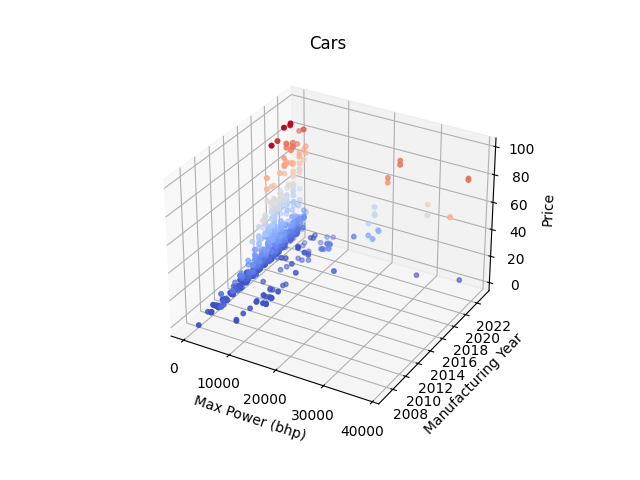

In [89]:
# PLOT CARS

%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

class DataPlot:
    def __init__(self):
        self.fig = plt.figure()
        self.ax: plt.Axes = None
        self.onetime_plots = []
        
    def draw(self):
        self.fig.canvas.draw_idle()
        display(self.fig)

        # Remove all one-time plots
        for i, onetime_plot in enumerate(self.onetime_plots):
            for handle in onetime_plot:
                handle.remove()
                self.onetime_plots.pop(i)
    
    def plot_once(self, plot):
        self.onetime_plots.append(plot)


data_plot = DataPlot()

if CONFIG['features'] == 1:
    data_plot.ax = data_plot.fig.add_subplot()
    data_plot.ax.scatter([car.max_power for car in cars], [car.price for car in cars])
    data_plot.ax.set_xlabel('Max Power (bhp)')
    data_plot.ax.set_ylabel('Price (lakhs)')
else:
    data_plot.ax = data_plot.fig.add_subplot(projection='3d')

    # For each set of style and range settings, plot n random points in the box
    # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
    xs = np.array([car.max_power for car in cars])
    ys = np.array([car.year for car in cars])
    zs = np.array([car.price for car in cars])
    data_plot.ax.scatter(xs, ys, zs, c = zs, cmap='coolwarm', s=10)

    data_plot.ax.set_xlabel('Max Power (bhp)')
    data_plot.ax.set_ylabel('Manufacturing Year')
    data_plot.ax.get_yaxis().set_major_locator(ticker.MaxNLocator(integer=True))
    data_plot.ax.set_zlabel('Price')
    
data_plot.ax.title.set_text('Cars')
data_plot.draw()

In [91]:
# SETUP REGRESSION MODEL

class RegressionModel:
    def __init__(self):
        self.w = np.zeros(CONFIG['features'])
        self.b = 0

    def predict(self, x):
        return np.dot(self.w, x) + self.b

    def train(self, data, lr=0.01, epochs=1):
        for _ in range(epochs):
            error_sum = np.zeros(CONFIG['features'])

            for x, y in data:
                error_sum += self.predict(x) - y
            
            delta_b = lr * error_sum / len(data)
                
            self.b -= delta_b
            self.w -= delta_b * x
        
    def cost(self, x, y):
        return 0.5 * ((self.predict(x) - y) ** 2)
    
    def cost_average(self, data):
        return sum([self.cost(x, y) for x, y in data]) / len(data)

model = RegressionModel()

learning_data = [(car.into_features(), car.price) for car in cars]

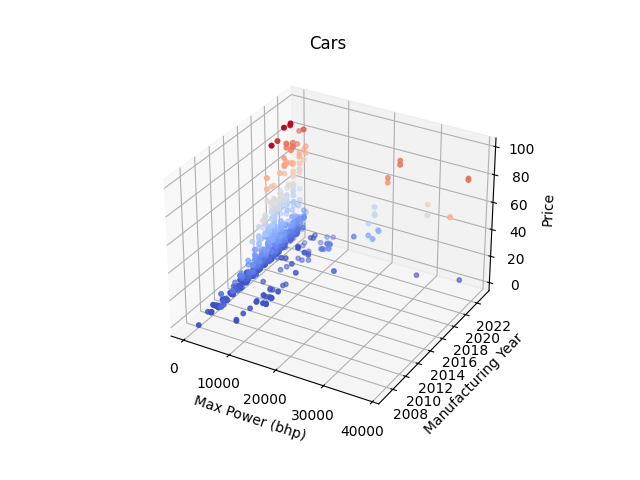

In [93]:
# TRAIN MODEL AND PLOT PROGRESS

model.train(learning_data, 0.0000001, 1)

# Plot cars

plot = None

if CONFIG['features'] == 1:
    # Plot univariate linear regression line
    x = np.linspace(0, 4e4, 100)
    y = model.predict(np.array([x]))
    x, y = zip(*[(x_val, y_val) for x_val, y_val in zip(x, y) if y_val < 100])
    data_plot.plot_once(data_plot.ax.plot(x, y, '-r'))
else:
    # Plot multiple linear regression surface
    x1 = np.linspace(2007, 2023, 100)
    x2 = np.linspace(0, 4e4, 100)
    X1, X2 = np.meshgrid(x1, x2)
    Y = np.zeros(X1.shape)
    
data_plot.draw()